# Some plots of index trends and all events compounding trends

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins


In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [4]:
# Here is the data
indecesXr = xarray.open_dataset('results/cesmTradIndeces.nc')

indecesXr.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

Same criteria as 'cesmIndeces' file

In [5]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesXr.sel(experiment=_model.cesmCntl).std(dim='year')

In [6]:
# define some criteria that we want to use to identifiy it thats an event. Its the same for evey experiment this time
criteriaXr= xarray.merge(
    (stdDa[['nino34','dmi']], stdDa['sam']/2)
)

criteriaXr = xarray.concat([
    criteriaXr for i in range(0,len(_model.cesmAll))
], 'experiment')
criteriaXr['experiment'] = _model.cesmAll

criteriaXr

<xarray.Dataset>
Dimensions:     (experiment: 18)
Coordinates:
  * experiment  (experiment) <U12 'LME.002' 'LME.003' 'LME.008' ... '012' '013'
Data variables:
    nino34      (experiment) float64 1.05 1.05 1.05 1.05 ... 1.05 1.05 1.05 1.05
    dmi         (experiment) float64 1.309 1.309 1.309 ... 1.309 1.309 1.309
    sam         (experiment) float64 0.6559 0.6559 0.6559 ... 0.6559 0.6559

# Plot time trends (nino is detrended)

CESM Model Run: LME.002


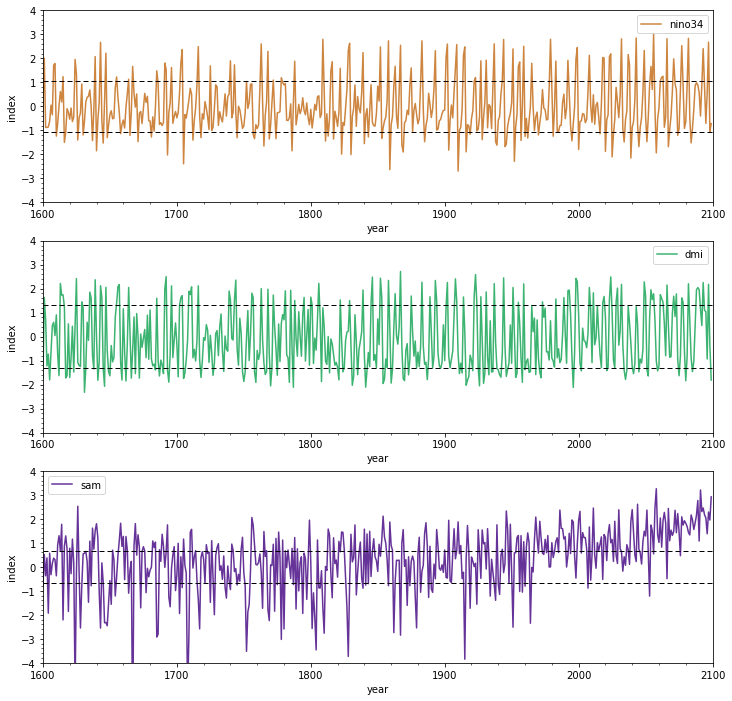

In [12]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'sam']
colors = ['peru', 'mediumseagreen', 'rebeccapurple']
lims = [(-4,4), [-4,4], [-4,4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    # plot the actual data
    plotData=indecesXr[indexToPlot[i]].sel(experiment=expToPlot) 
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    
    # draw some horizontal lines for criteria
    eventCrit=criteriaXr[indexToPlot[i]].sel(experiment=expToPlot).values
    plt.axhline(y=eventCrit, dashes=(5,3), color='black', linewidth=1)
    plt.axhline(y=-eventCrit, dashes=(5,3), color='black', linewidth=1)

    #Tidy up a bit
    plt.xlabel('year')
    plt.ylabel('index')
    plt.xlim(1600,2100)
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()


# Calculate the compounding years and plot an example

In [5]:
firePos=xarray.open_dataset('results/cesmFirePos.nc')

fireNeg=xarray.open_dataset('results/cesmFireNeg.nc')

NameError: name 'indexToPlot' is not defined

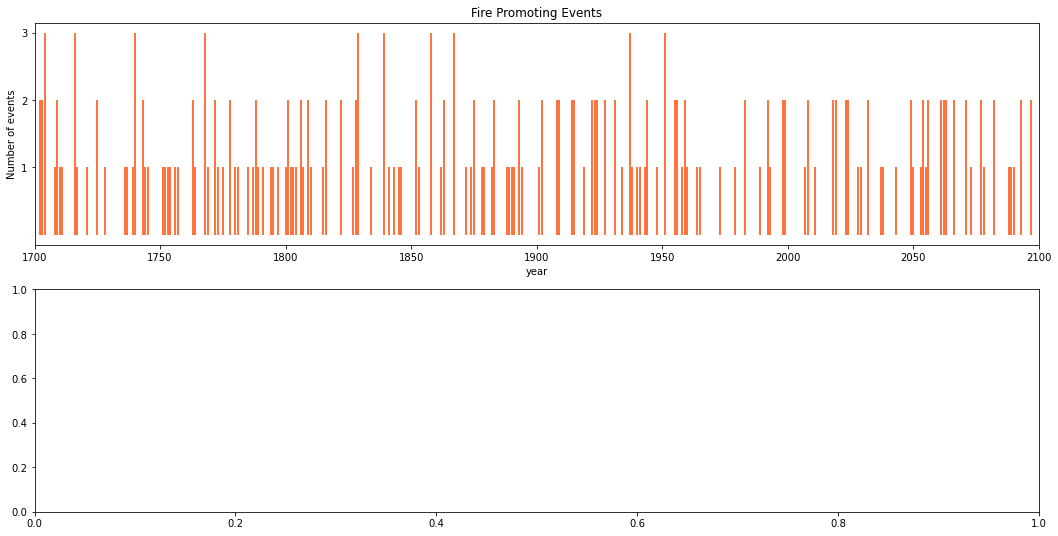

In [6]:
toPlot=(firePos.sel(experiment=expToPlot))

plt.figure(figsize=(18,9))

#plot the pos events in orange 

plt.subplot(2,1,1)

plt.vlines(
    x=toPlot.year, 
    ymin=0,
    ymax=toPlot.nEvents,
    colors='orangered', 
    label=expToPlot
)
plt.xlim(1700,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.yticks([1,2,3])
plt.title('Fire Promoting Events')

plt.subplot(2,1,2)
iPlot=0
for iIndex in indexToPlot:
    plt.vlines(
        x=(toPlot[iIndex].where(toPlot[iIndex])).year, 
        ymin=iPlot,
        ymax=(iPlot+1)*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        label=iIndex,
        linewidth=2
    )
    iPlot=iPlot+1
    plt.legend()
    plt.xlim(1700,2100)
    plt.xlabel('year')
    plt.ylim([0,3])
    plt.yticks([])


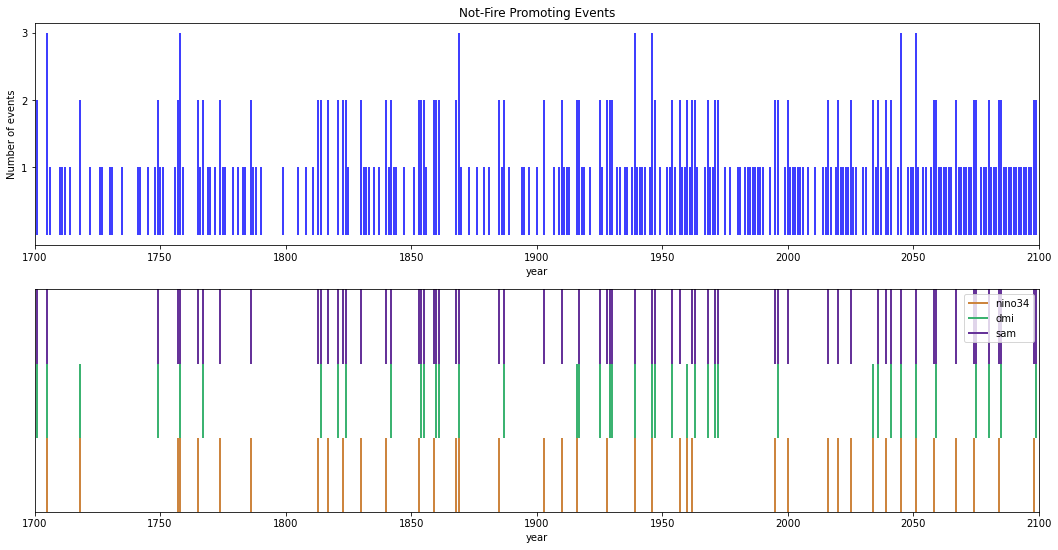

In [10]:
# and the neg count in blue

toPlot=(fireNeg.sel(experiment=expToPlot))

plt.figure(figsize=(18,9))

plt.subplot(2,1,1)
plt.vlines(
    x=toPlot.year, 
    ymin=0,
    ymax=toPlot.nEvents,
    colors='blue', 
    label=expToPlot
)
plt.xlim(1700,2100)
plt.xlabel('year')
plt.ylabel('Number of events')
plt.yticks([1,2,3])
plt.title('Not-Fire Promoting Events')


plt.subplot(2,1,2)
iPlot=0
for iIndex in indexToPlot:

    plt.vlines(
        x=(toPlot[iIndex].where(toPlot[iIndex])).year, 
        ymin=iPlot,
        ymax=(iPlot+1)*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        label=iIndex,
        linewidth=2
    )
    iPlot=iPlot+1
    plt.legend()
    plt.xlim(1700,2100)
    plt.xlabel('year')
    plt.ylim([0,3])
    plt.yticks([])


# Put the compounds into 30 year intervals

In [7]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid ).sum() 



binnedPosCount=(firePos.nEvents>1).groupby_bins('year', yearBins, labels=binMid).sum() 
binnedPosCount= binnedPosCount.rename({'year_bins':'year'})


binnedNegCount=(fireNeg.nEvents>1).groupby_bins('year', yearBins, labels=binMid).sum()
binnedNegCount= binnedNegCount.rename({'year_bins':'year'})

Plot of main ensemble runs over time

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for main ensemble runs.')

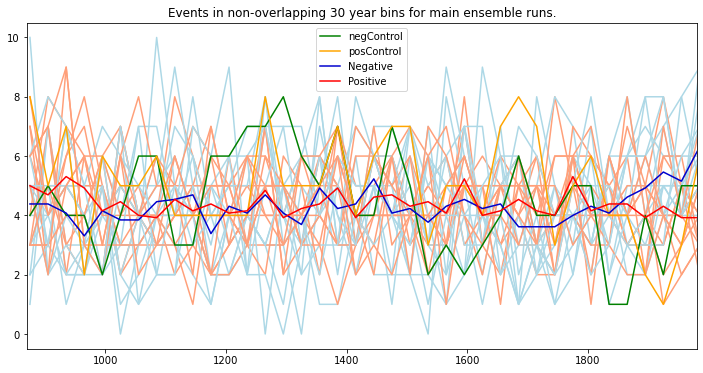

In [15]:
fig = plt.figure(figsize=(12,6))

for iExp in _model.cesmFullForcings:
    plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=iExp).values, color='lightblue')
    plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=iExp).values, color='lightsalmon')
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmCntl).values, color='green', label='negControl')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmCntl).values, color='orange', label='posControl')
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='mediumblue', label='Negative')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmFullForcings).mean(dim='experiment') , color='red', label = 'Positive')   

plt.xlim(870, 1980)
plt.legend()
plt.title('Events in non-overlapping 30 year bins for main ensemble runs.')

Plot of runs with RCP 8.5 forcings

Text(0.5, 1.0, 'Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

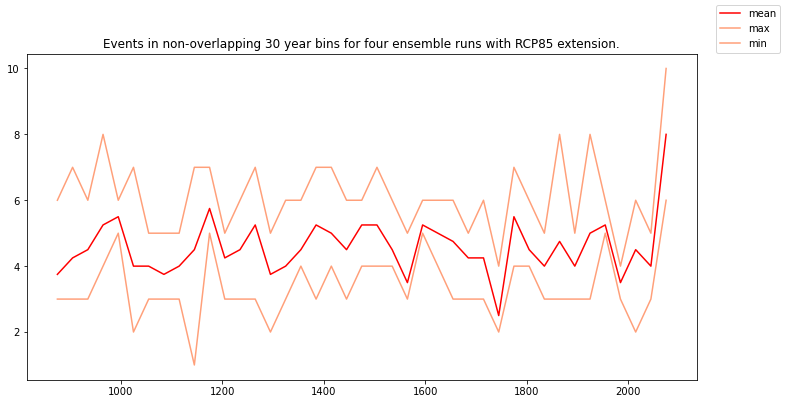

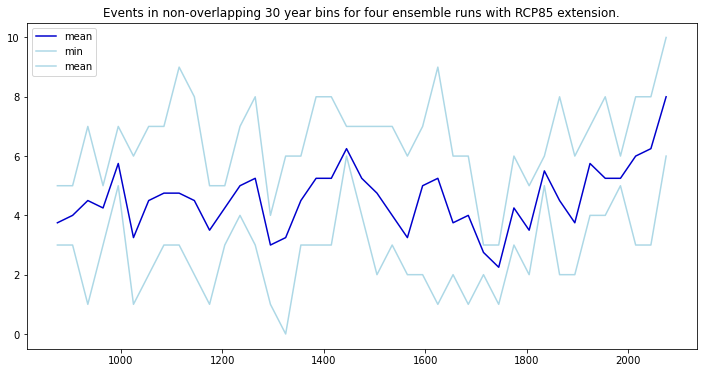

In [9]:
fig = plt.figure(figsize=(12,6))

    
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(binnedPosCount.year, binnedPosCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')

fig.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')



fig = plt.figure(figsize=(12,6))
    
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(binnedNegCount.year, binnedNegCount.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.title('Events in non-overlapping 30 year bins for four ensemble runs with RCP85 extension.')

# Overlapping bins

In [10]:
overlapBinFirePos=overlapBins.binSum(firePos.nEvents>1)
overlapBinFireNeg=overlapBins.binSum(fireNeg.nEvents>1)


In [11]:
overlapBinFireNeg

<xarray.DataArray 'nEvents' (year: 123, experiment: 18)>
array([[6., 5., 4., ..., 2., 6., 5.],
       [5., 4., 3., ..., 2., 6., 4.],
       [4., 4., 1., ..., 4., 8., 4.],
       ...,
       [6., 5., 6., ..., 0., 0., 0.],
       [6., 7., 9., ..., 0., 0., 0.],
       [7., 9., 9., ..., 0., 0., 0.]])
Coordinates:
  * experiment  (experiment) object 'LME.002' 'LME.003' ... '012' '013'
  * year        (year) int64 865 875 885 895 905 ... 2045 2055 2065 2075 2085
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

Text(0.5, 1.0, 'Not Fire-Promoting')

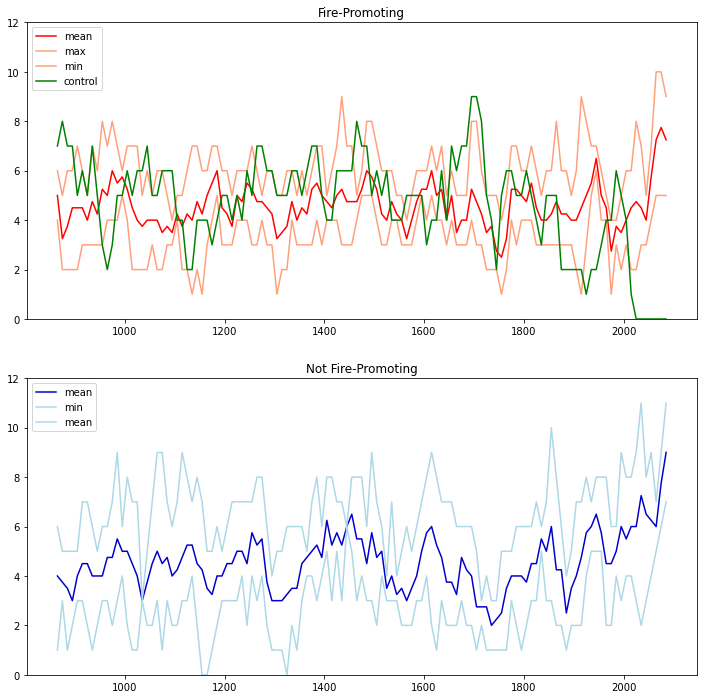

In [12]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
    
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='red', label='mean')   
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightsalmon', label='max')
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightsalmon', label='min')
plt.plot(overlapBinFirePos.year, overlapBinFirePos.sel(experiment=_model.cesmCntl).values , color='green', label='control')

plt.legend()

plt.ylim([0,12])
plt.title('Fire-Promoting')



plt.subplot(2,1,2)
    
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).mean(dim='experiment') , color='mediumblue', label='mean')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).max(dim='experiment') , color='lightblue', label='min')
plt.plot(overlapBinFireNeg.year, overlapBinFireNeg.sel(experiment=_model.cesmRcp85).min(dim='experiment') , color='lightblue', label='mean')

plt.legend()

plt.ylim([0,12])
plt.title('Not Fire-Promoting')

# Rolling 30 year intervals instead

(0.0, 8.0)

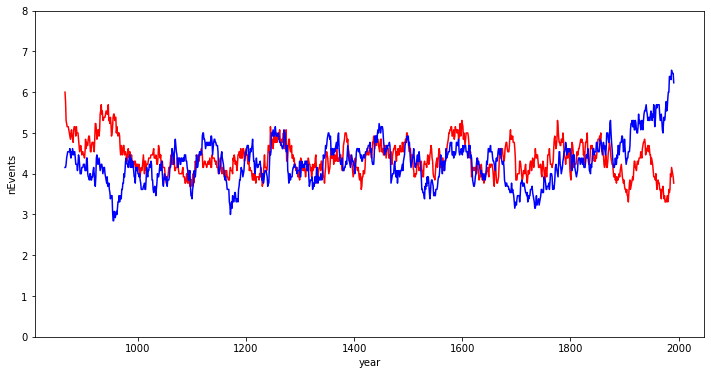

In [17]:
fig = plt.figure(figsize=(12,6))

rollingPCount=(
    firePos.nEvents.where(firePos.year<=2005, drop=True).sel(
    experiment=_model.cesmNoRepeats)>1
              ).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingPCount.mean(dim='experiment').plot(label='mean', color='red')

rollingNCount=(
    fireNeg.nEvents.where(fireNeg.year<=2005, drop=True).sel(experiment=_model.cesmNoRepeats)>1
).rolling(
    year=30, center=True
).sum('year').dropna('year')

rollingNCount.mean(dim='experiment').plot(label='mean', color='blue')


plt.ylim(0,8)